# Project 3 - Binary Classification (Reddit)

### business problem:
    help people to be able to just post their stuff without thinking which specific subreddit to go to. 
    based on their post, the model will recommend the user which of his post is categorised into. 

# Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import regex as re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer 
from sklearn.feature_extraction import stop_words
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction import text
from textblob import TextBlob

# Reading the 2 compiled sub-reddit posts

In [2]:
df1 = pd.read_csv('./Data/AITA_dd.csv')
df2 = pd.read_csv('./Data/TIFU_dd.csv')

# Data preparation 

In [3]:
# merge the AITA & TIFU posts
df = pd.concat([df1,df2],axis=0)

In [4]:
# drop unwanted columns
df.drop(labels = ['Unnamed: 0'], axis = 1, inplace = True)
df.reset_index(drop=True, inplace=True)

In [5]:
df['subreddit'] = df['subreddit'].apply(lambda i : 1 if i == 'tifu' else 0)

In [6]:
df

,subreddit,selftext,title
0,0,Hello everyone! We’re starting this new year o...,IMPORTANT: Rule Changes. /r/AITAFiltered. MUST...
1,0,"Hey everyone! As many of you know, we have bee...",[META] AITA Best of 2019 Awards RESULTS!
2,0,Original post: https://www.reddit.com/r/AmIthe...,"UPDATE: AITA for letting my brother call me ""d..."
3,0,After discussing the idea of having my adult s...,AITA for telling my therapist to F off?
4,0,I realize this title makes me sound like a com...,WIBTA for banning an autistic child from my we...
...,...,...,...
1415,1,"Needless to say, this is a throwaway account.\...","TIFU by leaving my zipper open, exposing sexy ..."
1416,1,The obligatory this happened a few years back ...,TIFU by mixing up the phonetic alphabet
1417,1,That's the gist. I needed to do a powerpoint f...,TIFU by submitting an assignment with my frien...
1418,1,"Obligatory: This didn’t happen today, rather 1...",TIFU by watching $800 worth of porn


# Data Cleaning: Checking and removing null values

In [7]:
df.isnull().sum()

subreddit    0
selftext     1
title        0
dtype: int64

In [8]:
df['text_features'] = df['selftext'] + df['title']

In [9]:
df.isnull().sum()

subreddit        0
selftext         1
title            0
text_features    1
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

subreddit        0
selftext         0
title            0
text_features    0
dtype: int64

# Visualizing the most occuring word in TIFU & AITA

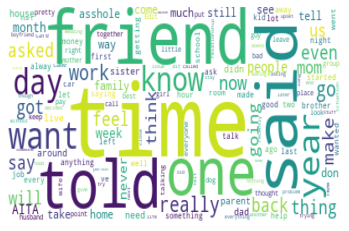

In [12]:
#AITA
# Join all text
AITA = " ".join(review for review in df[df['subreddit'] == 0]['selftext'])

# Create and generate a word cloud image:
wordcloud_AITA = WordCloud(collocations = False, background_color = 'white', max_words=150).generate(AITA)

# Display the generated image:
plt.imshow(wordcloud_AITA, interpolation = 'bilinear',aspect ='auto')
plt.axis('off')

# Store to file
plt.savefig('./Data/AITA_word_cloud.png',format='png')
plt.show()

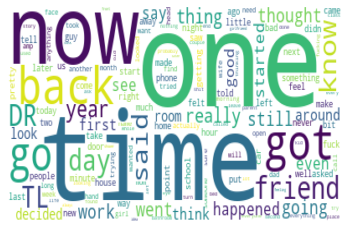

In [13]:
#TIFU
# Join all text
TIFU = " ".join(review for review in df[df['subreddit'] == 1]['selftext'])

# Create and generate a word cloud image:
wordcloud_TIFU = WordCloud(collocations = False, background_color = 'white', max_words=150).generate(TIFU)

# Display the generated image:
plt.imshow(wordcloud_TIFU, interpolation = 'bilinear',aspect ='auto')
plt.axis('off')

# Store to file
plt.savefig('./Data/TIFU_word_cloud.png',format='png')
plt.show()

# Train-Test Split of Data

In [14]:
df.head()

,subreddit,selftext,title,text_features
0,0,Hello everyone! We’re starting this new year o...,IMPORTANT: Rule Changes. /r/AITAFiltered. MUST...,Hello everyone! We’re starting this new year o...
1,0,"Hey everyone! As many of you know, we have bee...",[META] AITA Best of 2019 Awards RESULTS!,"Hey everyone! As many of you know, we have bee..."
2,0,Original post: https://www.reddit.com/r/AmIthe...,"UPDATE: AITA for letting my brother call me ""d...",Original post: https://www.reddit.com/r/AmIthe...
3,0,After discussing the idea of having my adult s...,AITA for telling my therapist to F off?,After discussing the idea of having my adult s...
4,0,I realize this title makes me sound like a com...,WIBTA for banning an autistic child from my we...,I realize this title makes me sound like a com...


In [15]:
X = df['text_features']
y = df['subreddit']

In [16]:
# Base Accuracy reference
pd.value_counts(y,normalize = True)

0    0.574348
1    0.425652
Name: subreddit, dtype: float64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [18]:
X_train.shape

(1064,)

In [19]:
y_train.shape

(1064,)

# Data Cleaning: Handling Stop-Words with TextBlob

In [20]:
# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.lemmatize() for token in tokens]
    return words

In [21]:
#Tokenize & lemmatize stop word
sets=[text.ENGLISH_STOP_WORDS]
stop_words = [list(x) for x in sets]
sw = [textblob_tokenizer(i) for i in stop_words[0]]

In [65]:
# making tokenize stop word into a list
sw1=[]
for i in sw:
    for j in i:
        sw1.append(j)
        
words = ['TIFU','tifu','AITA','aita','s']        
sw1.extend(words)

# 1) Grid-Search for Logistic Regression using pipeline & Cross Validation

## 1a) Using CountVectorizer

In [23]:
pipe_lr = Pipeline([(  'cvec', CountVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer )  ),
                    (  'lr', LogisticRegression(solver='liblinear')  )])

In [24]:
pipe_params_lr = {'cvec__max_features': [300,500,600],
                  'cvec__min_df' : [3,5],
                  'cvec__max_df' : [0.9,0.99],
                  'cvec__ngram_range': [(1,1), (1,2)],
                  'lr__penalty': ['l1','l2']
                 }
gs_lr = GridSearchCV(pipe_lr, param_grid=pipe_params_lr, verbose=1, cv=3)
gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_)
gs_lr.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 14.9min finished


0.9558270676691729


{'cvec__max_df': 0.99,
 'cvec__max_features': 600,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'lr__penalty': 'l1'}

In [25]:
gs_lr.score(X_train, y_train)

1.0

In [26]:
gs_lr.score(X_test, y_test)

0.9577464788732394

#### 1a) Transforming and fitting the logistic model with best parameters

In [95]:
cvec = CountVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer, max_df = 0.99,
                max_features = 600,min_df=5,ngram_range =(1, 2))

In [96]:
cvec.fit(X_train)
X_train_CV = cvec.transform(X_train)
X_test_CV = cvec.transform(X_test)

In [97]:
# Fitting in the Logistic Regression model with best params 
CV_lr = LogisticRegression(solver='liblinear',penalty = 'l1')
CV_lr.fit(X_train_CV,y_train)
y_pred = CV_lr.predict(X_test_CV)
lr_c = accuracy_score(y_test,y_pred)
print('accuracy score',lr_c)

accuracy score 0.9577464788732394


## 1b) Using Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

In [30]:
pipe_lr = Pipeline([(  'tvec', TfidfVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer )  ),
                    (  'lr', LogisticRegression(solver='liblinear')  )])

In [31]:
pipe_params_lr = {'tvec__max_features': [300,500,600],
                  'tvec__min_df' : [3,5],
                  'tvec__max_df' : [0.9,0.99],
                  'tvec__ngram_range': [(1,1), (1,2)],
                  'lr__penalty': ['l1','l2']
                 }
gs_lr = GridSearchCV(pipe_lr, param_grid=pipe_params_lr, verbose=1, cv=3)
gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_)
gs_lr.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 15.2min finished


0.9426691729323309


{'lr__penalty': 'l1',
 'tvec__max_df': 0.9,
 'tvec__max_features': 300,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}

#### 1b) Transforming and fitting the logistic model with best parameters

In [69]:
tvec = TfidfVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer,
                       max_df = 0.9 ,max_features = 300 ,min_df= 3 ,ngram_range =(1,1))

In [70]:
tvec.fit(X_train)
X_train_TV = tvec.transform(X_train)
X_test_TV = tvec.transform(X_test)

In [71]:
# Fitting in the Logistic Regression model with best params 
TV_lr = LogisticRegression(solver='liblinear',penalty = 'l1')
TV_lr.fit(X_train_TV,y_train)
y_pred = TV_lr.predict(X_test_TV)
lr_t = accuracy_score(y_test,y_pred)
print('accuracy score',lr_t)

accuracy score 0.9549295774647887


#### Getting the words that are being classified into the respective sub-reddits. 0 = AITA, 1 = TIFU

Text(0.5, 1.0, 'top 15 key-tokens in AITA & TIFU Sub-reddit post ')

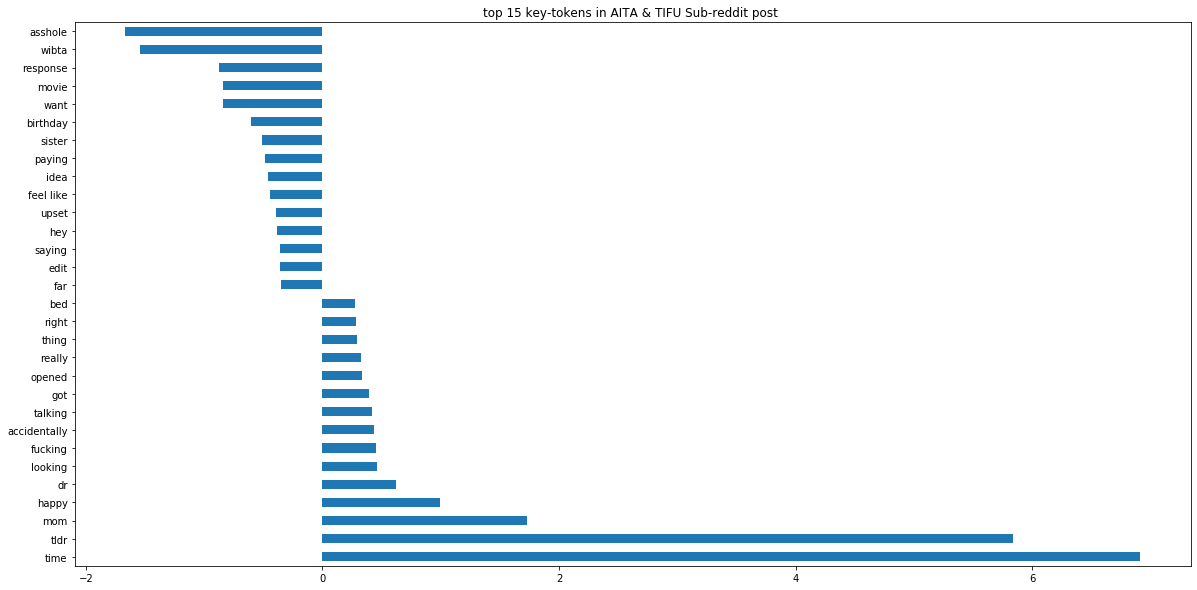

In [72]:
lr_coef = pd.DataFrame(CV_lr.coef_,columns = columns)
df_coef = lr_coef.T.sort_values(by = 0, ascending = False)

top_coef = pd.concat([df_coef.head(15),
                      df_coef.tail(15)])
plt.rcParams['figure.figsize'] = (20.0, 10.0)
top_coef.plot(kind = "barh", legend = False)
plt.title("top 15 key-tokens in AITA & TIFU Sub-reddit post ")

# 2) Grid-Search for Multinomial (Bayes) using pipeline & Cross Validation

## 2a) Using CountVectorizer

In [57]:
pipe_nb = Pipeline([(  'cvec', CountVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer)  ),
                    (  'nb', MultinomialNB()  )])

In [58]:
pipe_params_nb = {'cvec__max_features': [300,500,600],
                  'cvec__min_df' : [3,5],
                  'cvec__max_df' : [0.9,0.99],
                  'cvec__ngram_range': [(1,1), (1,2)],
                 }
gs_nb = GridSearchCV(pipe_nb, param_grid=pipe_params_nb, verbose=1, cv=3)
gs_nb.fit(X_train, y_train)
print(gs_nb.best_score_)
gs_nb.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  7.5min finished


0.8853383458646616


{'cvec__max_df': 0.9,
 'cvec__max_features': 600,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [59]:
gs_nb.score(X_train, y_train)

0.9135338345864662

In [60]:
gs_nb.score(X_test, y_test)

0.8873239436619719

#### 2a) Transforming and fitting the mulltinomial model with best parameters

In [73]:
cvec = CountVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer, max_df = 0.9,
                max_features = 600,min_df=3,ngram_range =(1, 1))

In [74]:
cvec.fit(X_train)
X_train_CV = cvec.transform(X_train)
X_test_CV = cvec.transform(X_test)

In [75]:
# Fitting in the Multinomial model with best params 
nb = MultinomialNB()
nb.fit(X_train_CV,y_train)
y_pred = nb.predict(X_test_CV)
nb_c = accuracy_score(y_test,y_pred)
print('accuracy score',nb_c)

accuracy score 0.9042253521126761


## 2b) Using Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

In [76]:
pipe_lr = Pipeline([(  'tvec', TfidfVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer )  ),
                    (  'nb', MultinomialNB()  )])

In [77]:
pipe_params_lr = {'tvec__max_features': [300,500,600],
                  'tvec__min_df' : [3,5],
                  'tvec__max_df' : [0.9,0.99],
                  'tvec__ngram_range': [(1,1), (1,2)],
                 }
gs_lr = GridSearchCV(pipe_lr, param_grid=pipe_params_lr, verbose=1, cv=3)
gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_)
gs_lr.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  7.6min finished


0.8881578947368421


{'tvec__max_df': 0.9,
 'tvec__max_features': 600,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

#### 2b) Transforming and fitting the multinomial model with best parameters

In [78]:
tvec = TfidfVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer,
                       max_df = 0.9 ,max_features = 600 ,min_df= 3 ,ngram_range =(1,2))

In [79]:
tvec.fit(X_train)
X_train_TV = tvec.transform(X_train)
X_test_TV = tvec.transform(X_test)

In [80]:
# Fitting in the Multinomial model with best params 
nb = MultinomialNB()
nb.fit(X_train_TV,y_train)
y_pred = nb.predict(X_test_TV)
nb_t = accuracy_score(y_test,y_pred)
print('accuracy score',nb_t)

accuracy score 0.8816901408450705


# 3) Grid-Search for Random Forest using pipeline & Cross Validation

## 3a) Using CountVectorizer

In [82]:
pipe_rf = Pipeline([(  'cvec', CountVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer)  ),
                    (  'rf', RandomForestClassifier(n_estimators=100)  )])

In [83]:
pipe_params_rf = {'cvec__max_features': [300,500,600],
                  'cvec__min_df' : [3,5],
                  'cvec__max_df' : [0.9,0.99],
                  'cvec__ngram_range': [(1,1), (1,2)],
                  'rf__n_estimators': [100, 200],
                  'rf__max_depth': [None, 1, 2],
                  'rf__max_features' :[1,2]
              }
gs_rf = GridSearchCV(pipe_rf, param_grid=pipe_params_rf, verbose=1, cv=3)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed: 93.8min finished


0.9342105263157895


{'cvec__max_df': 0.99,
 'cvec__max_features': 300,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': None,
 'rf__max_features': 2,
 'rf__n_estimators': 200}

#### 3a) Transforming and fitting the Random Tree model with best parameters

In [84]:
cvec = CountVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer,
                       max_df=0.99,max_features=300,min_df=5,ngram_range=(1, 1))

In [85]:
cvec.fit(X_train)
X_train_CV = cvec.transform(X_train)
X_test_CV = cvec.transform(X_test)

In [86]:
# Fitting in the Random Forest model with best params 
rf = RandomForestClassifier(max_depth=None,max_features=2, n_estimators = 200)
rf.fit(X_train_CV,y_train)
y_pred = rf.predict(X_test_CV)
rf_c = accuracy_score(y_test,y_pred)
print('accuracy score', rf_c)

accuracy score 0.9464788732394366


## 3b) Using Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

In [87]:
pipe_rf = Pipeline([(  'tvec', TfidfVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer)  ),
                    (  'rf', RandomForestClassifier(n_estimators=100)  )])

In [88]:
pipe_params_rf = {'tvec__max_features': [300,500,600],
                  'tvec__min_df' : [3,5],
                  'tvec__max_df' : [0.9,0.99],
                  'tvec__ngram_range': [(1,1), (1,2)],
                  'rf__n_estimators': [100, 200],
                  'rf__max_depth': [None, 1, 2],
                  'rf__max_features' :[1,2]
              }
gs_rf = GridSearchCV(pipe_rf, param_grid=pipe_params_rf, verbose=1, cv=3)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed: 100.7min finished


0.9285714285714286


{'rf__max_depth': None,
 'rf__max_features': 2,
 'rf__n_estimators': 200,
 'tvec__max_df': 0.99,
 'tvec__max_features': 600,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

#### 3b) Transforming and fitting the Random Tree model with best parameters

In [89]:
tvec = TfidfVectorizer(stop_words = sw1,tokenizer=textblob_tokenizer,
                       max_df = 0.99 ,max_features = 600 ,min_df= 5 ,ngram_range =(1,2))

In [90]:
tvec.fit(X_train)
X_train_TV = tvec.transform(X_train)
X_test_TV = tvec.transform(X_test)

In [91]:
# Fitting in the Multinomial model with best params 
rf = RandomForestClassifier(n_estimators=200, max_features=2, max_depth=None)
rf.fit(X_train_TV,y_train)
y_pred = rf.predict(X_test_TV)
rf_t = accuracy_score(y_test,y_pred)
print('accuracy score',rf_t)

accuracy score 0.9323943661971831


# Selecting the best model and do prediction 

In [92]:
print(lr_c, lr_t, nb_c, nb_t, rf_c, rf_t)

0.9577464788732394 0.9549295774647887 0.9042253521126761 0.8816901408450705 0.9464788732394366 0.9323943661971831


| Model                                       | Score  |
|---------------------------------------------|--------|
| Logistic Regression \(Count Vectorizer\)    | 0\.958 |
| Logistic Regression \(TF\-IDF\)             | 0\.955 |
| Multinomial Classifier \(Count Vectorizer\) | 0\.904 |
| Multinomial Classifier \(TF\-IDF\)          | 0\.882 |
| Random Forest \(Count Vectorizer\)          | 0\.946 |
| Random Forest \(TF\-IDF\)                   | 0\.932 |

Model Selected : Logistic Regression with Count Vectorizer 

In [109]:
predictions = CV_lr.predict(X_test_CV)

In [110]:
lr.score(X_train_CV, y_train)

0.950187969924812

In [111]:
lr.score(X_test_CV, y_test)

0.9408450704225352

In [112]:
accuracy_score(y_test,y_pred)

0.9577464788732394

#### Looking at the condusion matrix 

In [101]:
confusion_matrix(y_test, predictions)

array([[196,   8],
       [  7, 144]])

In [102]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [103]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 196
False Positives: 8
False Negatives: 7
True Positives: 144


In [104]:
spec = tn / (tn + fp)
print(f'Specificity: {round(spec,4)}')

Specificity: 0.9608


In [105]:
sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9536


In [106]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.
pred_proba = [i[1] for i in lr.predict_proba(X_test_CV)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
476,0,0.001110
619,0,0.057991
774,0,0.073372
134,0,0.145276
887,1,0.526174
...,...,...
241,0,0.852041
389,0,0.026424
232,0,0.000011
387,0,0.000206


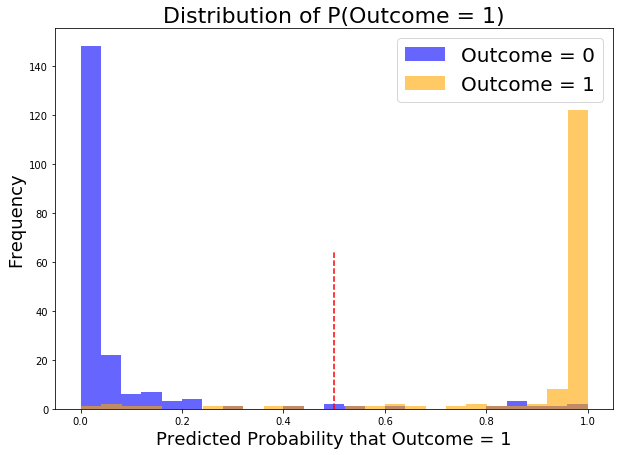

In [107]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Investigating the False Negatively Classified tokens

In [113]:
# Making a dataframe to display y_test, y_predict and tokenized X_test
df_y = pd.DataFrame(y_test)
df_y['y_pred'] = y_pred
df_y['X_test'] = X_test
df_y.rename(columns = {'subreddit':'y_test','y_pred':'y_pred','X_test':'X_test'},inplace=True)
df_y['X_test'] = df_y['X_test'].apply(textblob_tokenizer)
df_y.head()

,y_test,y_pred,X_test
476,0,0,"[i, work, for, a, university, chair, that, doe..."
619,0,0,"[im, pretty, frustrated, over, here, started, ..."
774,0,0,"[so, last, week, one, of, my, friend, friend, ..."
134,0,0,"[my, hearing, suck, always, ha, if, there, 's,..."
887,1,1,"[today, wa, my, 22m, girlfriend, ’, s, 29f, bi..."


In [114]:
# Selecting just the false negative classified tokens into a dataframe
df_fn = df_y[(df_y['y_test']== 1) & (df_y['y_pred']== 0)]
df_fn

,y_test,y_pred,X_test
829,1,0,"[this, happened, today, throwaway, account, fo..."
1285,1,0,"[this, happened, to, me, on, monday, but, i, w..."
935,1,0,"[today, i, posted, on, a, local, facebook, com..."
861,1,0,"[after, calming, down, and, laughing, about, t..."
1333,1,0,"[last, night, i, wa, messing, around, online, ..."
815,1,0,"[welcome, to, the, nomination, thread, for, th..."
951,1,0,"[so, some, background, i, am, a, married, to, ..."


In [115]:
# Create a list for all the coefficients that help to classify post into AITA (subreddit =0)
wrong_token =[]
df_AITAcoef = df_coef[df_coef[0]<0]
AITA_token = list(df_AITAcoef.index.values)
# Locate the token that causes false negative classification
for i in df_fn['X_test']:
    for j in i:
        if j in AITA_token:
            wrong_token.append(j)
wrong_token = set(wrong_token)
wrong_token

{'1',
 'asked',
 'asshole',
 'class',
 'college',
 'comment',
 'doe',
 'don',
 'far',
 'guess',
 'joke',
 'let',
 'little',
 'make',
 'moment',
 'month',
 "n't",
 'nice',
 'parent',
 'person',
 'response',
 'room',
 'said',
 'saying',
 'sister',
 'texted',
 'thought',
 'told',
 'try',
 'understand',
 'walk',
 'want',
 'week',
 'woman',
 'work',
 'year',
 '’',
 '“'}